# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [3]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [7]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.33e07b58f54547908b819252935c2b24 Dashboard: /services/dask-gateway/clusters/staging.33e07b58f54547908b819252935c2b24/status,Cluster Workers: 7 Cores: 14 Memory: 56.00 GiB


In [8]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm
xr.set_options(display_style='text')

In [9]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
    topo = xr.open_dataset(fp)

In [10]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [11]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [12]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [ ]:
topo.ds_10_12_T#.max()

In [ ]:
topo.depth.max()

In [ ]:
topo.depth

In [13]:
ds_wg = ocean.isel(**lat_range, **lon_range)
depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [ ]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

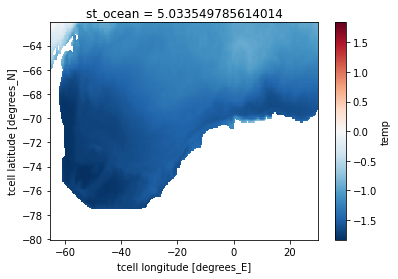

In [9]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).mean(dim='time')
sst_mean.plot()

## <span style='color:Red'> Bottom Potential Temperatures

In [14]:
grid_transport = xgcm.Grid(ds_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() & ds_wg.temp.st_ocean.max())

In [16]:
ds_wg.temp.where(ds_wg.temp.notnull()) & ds_wg.temp.st_ocean.max()

TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'bitwise_and'>, '__call__', dask.array<where, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>, array([[[[5395.02294922]]]])): 'Array', 'ndarray'

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() is True).argmax(dim='st_ocean')[0].plot()

In [40]:
ds_wg.temp.where(ds_wg.temp.notnull() is True) and ds_wg.temp.idxmax(dim='st_ocean')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull() is True)

In [16]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull()).argmax(dim='st_ocean')

<xarray.DataArray 'temp' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<nanarg_agg-aggregate, shape=(1970, 169, 381), dtype=int64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [17]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull()).idxmax(dim='st_ocean')

<xarray.DataArray 'st_ocean' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<where, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

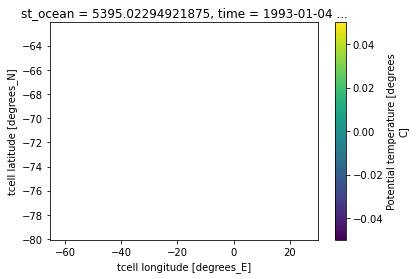

In [22]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull())[0, -1].plot()

In [25]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull()).where(ds_wg.temp.notnull().max(dim='st_ocean'))

<xarray.DataArray 'temp' (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<where, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [40]:
#999 is ocean, 111 is land
hfacc = ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull(), 999).where(ds_wg.temp < 999, 111)

In [65]:
hfacc

<xarray.DataArray 'temp' (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<where, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

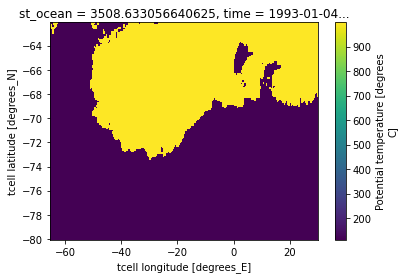

In [74]:
hfacc[0,-10].plot()

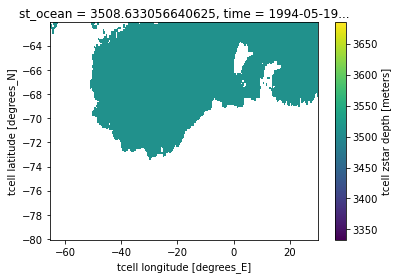

In [76]:
depth_max100 = ds_wg.st_ocean.where(hfacc.isel(time=100) == 999).isel(st_ocean=-10)#.max(dim='st_ocean')
depth_max100.load()
depth_max100.plot()

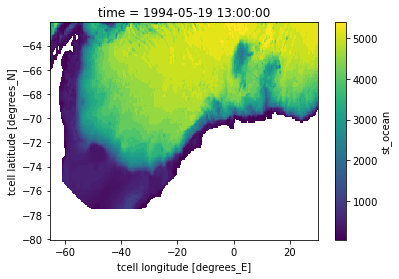

In [81]:
depth_max100 = (ds_wg.st_ocean.where(hfacc.isel(time=100) == 999)).max(dim='st_ocean')
depth_max100.load()
depth_max100.plot()

In [86]:
depth_max100.isel(yt_ocean=-1, xt_ocean=-1)

<xarray.DataArray 'st_ocean' ()>
array(5185.11083984)
Coordinates:
    time      object 1994-05-19 13:00:00
    xt_ocean  float64 29.88
    yt_ocean  float64 -62.14

In [89]:
ds_wg.st_ocean.sel(st_ocean=5185.11083984, method='nearest')

<xarray.DataArray 'st_ocean' ()>
array(5185.11083984)
Coordinates:
    st_ocean  float64 5.185e+03
Attributes:
    cartesian_axis:  Z
    edges:           st_edges_ocean
    long_name:       tcell zstar depth
    positive:        down
    units:           meters

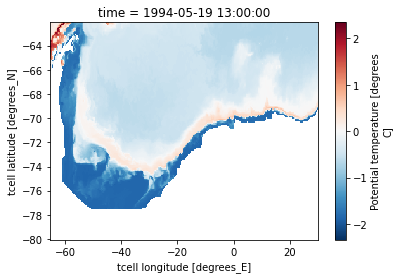

In [92]:
ds_wg.temp.isel(time=100).sel(st_ocean=depth_max100, method='nearest').plot()

In [ ]:
depth_max = (ds_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

In [ ]:
bottom_temp = ds_wg.temp.sel(st_ocean=depth_max, method='nearest')

In [64]:
ds_wg.st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([5.033550e+00, 1.510065e+01, 2.521935e+01, 3.535845e+01, 4.557635e+01,
       5.585325e+01, 6.626175e+01, 7.680285e+01, 8.757695e+01, 9.862325e+01,
       1.100962e+02, 1.221067e+02, 1.349086e+02, 1.487466e+02, 1.640538e+02,
       1.813125e+02, 2.012630e+02, 2.247773e+02, 2.530681e+02, 2.875508e+02,
       3.300078e+02, 3.823651e+02, 4.467263e+02, 5.249824e+02, 6.187031e+02,
       7.286921e+02, 8.549935e+02, 9.967153e+02, 1.152376e+03, 1.319997e+03,
       1.497562e+03, 1.683057e+03, 1.874788e+03, 2.071252e+03, 2.271323e+03,
       2.474043e+03, 2.678757e+03, 2.884898e+03, 3.092117e+03, 3.300086e+03,
       3.508633e+03, 3.717567e+03, 3.926813e+03, 4.136251e+03, 4.345864e+03,
       4.555566e+03, 4.765369e+03, 4.975209e+03, 5.185111e+03, 5.395023e+03])
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Attributes:
    cartesian_axis:  Z
    edges:           st_edges_ocean
    long_name:       tcell zstar depth
    positive:        down
    units:           meters

In [69]:
ds_wg.temp.isel(time=100).sel(st_ocean=depth_max100.astype('i4'))

KeyError: "not all values found in index 'st_ocean'"

In [33]:
ds_wg.temp.st_ocean.max(dim='st_ocean').where(ds_wg.temp == ds_wg.temp.notnull()).where(ds_wg.temp.notnull().max(dim='st_ocean'))[0].sum('st_ocean').plot()

<xarray.DataArray 'st_ocean' ()>
array(5395.02294922)

In [31]:
ds_wg.temp.st_ocean.max(dim='st_ocean').where(ds_wg.temp == ds_wg.temp.notnull()).where(ds_wg.temp.notnull().max(dim='st_ocean'))[0,-1]#.plot()

<xarray.DataArray 'st_ocean' (yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(169, 381), dtype=float64, chunksize=(169, 381), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 5.395e+03
    time      object 1993-01-04 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [47]:
ds_wg.temp.notnull().idxmax(dim='st_ocean')#[0].plot()

<xarray.DataArray 'st_ocean' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<reshape, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [25]:
ds_wg.temp.where(ds_wg.temp.notnull()).argmax(dim='st_ocean')[0].plot()

ValueError: All NaN slice encountered

In [11]:
#this gives us the deargmaxf the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

In [12]:
ds_wg.temp.st_ocean.max()

<xarray.DataArray 'st_ocean' ()>
array(5395.02294922)

In [ ]:
#this gives us the depth of the bottom cell
depth_max = ds_wg.st_ocean.where(depth_wg.max()).max(dim='st_ocean').load()

In [ ]:
ds_wg.temp.shape

In [ ]:
depth_wg.shape

In [ ]:
ds_wg.temp[0,-1,:,:].plot()

In [ ]:
ds_wg.temp.st_ocean.max()

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() & ds_wg.temp.st_ocean.max())

In [ ]:
depth_wg.plot()

In [ ]:
depth_max.plot()

In [ ]:
bottom_temp = ds_wg.temp.sel(st_ocean=depth_max)#.fillna(0.).astype('i4'))
bottom_temp

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)